In [1]:
# example of loading the fashion_mnist dataset
from keras.datasets.fashion_mnist import load_data
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
import numpy as np
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


In [2]:
def show_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

In [13]:
def define_discriminator(in_shape=(28,28,1)):
	model = tf.keras.Sequential()
	# downsample
	model.add(tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
	model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
	# downsample
	model.add(tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
	# downsample
	model.add(tf.keras.layers.Conv2D(64, (3,3), strides=(2,2), padding='same'))
	model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
	# downsample
	model.add(tf.keras.layers.Conv2D(64, (4,4)))
	model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
	# classifier
	model.add(tf.keras.layers.Flatten())
	model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
	# compile model
	opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [14]:
def define_generator(latent_dim):
	model = tf.keras.Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(tf.keras.layers.Dense(n_nodes, input_dim=latent_dim))
	model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
	model.add(tf.keras.layers.Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
	# generate
	model.add(tf.keras.layers.Conv2D(1, (7,7), activation='tanh', padding='same'))
	return model

In [15]:
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = tf.keras.Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [16]:
# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = np.expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

In [17]:
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = tf.ones((n_samples, 1))
	return X, y

In [18]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [23]:
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = np.zeros((n_samples, 1))
	return X, y

In [24]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=1024):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = np.ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
		print('>%d, d1=%.3f, d2=%.3f g=%.3f' %
			(i+1,  d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('my_generator_20.h5')

In [25]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()

In [26]:
train(generator, discriminator, gan_model, dataset, latent_dim)

>1, d1=0.007, d2=0.039 g=3.530
>2, d1=0.618, d2=0.524 g=1.150
>3, d1=0.621, d2=0.718 g=0.816
>4, d1=0.591, d2=0.585 g=0.941
>5, d1=0.631, d2=0.582 g=0.993
>6, d1=0.633, d2=0.625 g=0.910
>7, d1=0.709, d2=0.600 g=0.903
>8, d1=0.642, d2=0.687 g=0.770
>9, d1=0.650, d2=0.650 g=0.865
>10, d1=0.611, d2=0.653 g=0.836
>11, d1=0.612, d2=0.661 g=0.835
>12, d1=0.579, d2=0.618 g=0.909
>13, d1=0.658, d2=0.642 g=0.843
>14, d1=0.651, d2=0.681 g=0.819
>15, d1=0.582, d2=0.743 g=0.775
>16, d1=0.641, d2=0.676 g=0.793
>17, d1=0.678, d2=0.664 g=0.823
>18, d1=0.668, d2=0.650 g=0.853
>19, d1=0.656, d2=0.663 g=0.797
>20, d1=0.668, d2=0.669 g=0.809


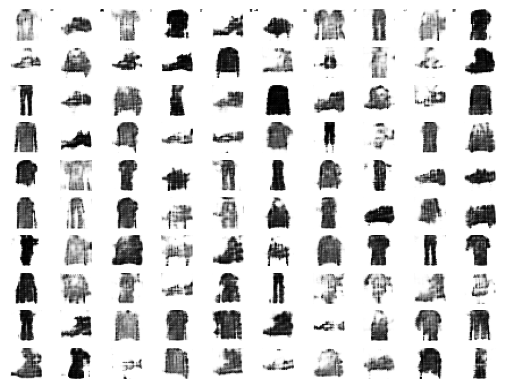

In [36]:
model = keras.models.load_model('my_generator_20.h5', compile = False)
latent_points = generate_latent_points(100, 100)
X = model.predict(latent_points)
show_plot(X, 10)